# PAE sampling and Laplace evidence calculation in z-space

In [1]:

#To make tf 2.0 compatible with tf1.0 code, we disable the tf2.0 functionalities
#tf.disable_eager_execution()
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import rcParams
import sys
import pickle
from functools import partial
import time
from tqdm import tqdm

plt.rcParams.update({'font.family' : 'lmodern', 'font.size': 16,                                                                                                                                                    
                     'axes.labelsize': 16, 'legend.fontsize': 12, 
                     'xtick.labelsize': 16, 'ytick.labelsize': 16, 'axes.titlesize': 16,
                     'axes.linewidth': 1.5})

In [2]:
import scipy

In [3]:
import tensorflow as tf
import tensorflow_probability as tfp
import tensorflow_hub as hub
import tensorflow_datasets as tfd
tfd = tfp.distributions
tfb = tfp.bijectors
tf.__version__
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
print(tf.__version__, tfp.__version__, hub.__version__)

2.2.0 0.10.0 0.8.0


### Loading the trained modules and evaluating logp in tensorflow

In [7]:
PROJECT_PATH = './'
MODULES_PATH = os.path.join(PROJECT_PATH,'PAE_samples/FMNIST/latent_dim32/PAE/modules')
param_file   = 'params_fmnist_-1_32_infoGAN_AE_full_sigma'
params       = pickle.load(open(os.path.join(MODULES_PATH,param_file+'.pkl'),'rb'))
params['module_dir'] = MODULES_PATH

In [8]:
x_train, _ = tfds.as_numpy(tfds.load('fashion_mnist',split='train',batch_size=-1,as_supervised=True,))
x_test, _  = tfds.as_numpy(tfds.load('fashion_mnist',split='test',batch_size=-1,as_supervised=True,))
x_train = (x_train/256.-0.5).astype(np.float32)
x_test  = (x_test/256.-0.5).astype(np.float32)

In [9]:
generator_path   = os.path.join(params['module_dir'],'decoder')
encoder_path     = os.path.join(params['module_dir'],'encoder')
nvp_path         = os.path.join(params['module_dir'],'nvp')

In [10]:
def get_likelihood(decoder,sigma):
    sigma = tf.reshape(sigma,(params['batch_size'],-1))
    def likelihood(z):
        mean  = decoder({'z':z})['x']
        mean  = tf.reshape(mean,(params['batch_size'],-1))
        
        LL = tfd.MultivariateNormalDiag(loc=mean,scale_diag=sigma)
        return tfd.Independent(LL)

    return likelihood

In [ ]:

sigma         = params['full_sigma']
sigma         = sigma.astype(np.float32)
print(sigma.shape)
encoder       = hub.KerasLayer(encoder_path,trainable=False, signature_outputs_as_dict=True)
decoder       = hub.KerasLayer(generator_path, trainable=False, signature_outputs_as_dict=True)
nvp_funcs     = hub.KerasLayer(nvp_path, trainable=False, signature_outputs_as_dict=True)

likelihood    = get_likelihood(decoder,np.repeat(np.expand_dims(sigma,0),params['batch_size'],axis=0))

In [12]:
def build_container(z):
    filler = np.zeros((params['batch_size'],len(z)))
    filler[0] = z
    return filler

In [13]:
def get_encoded(x):
    mu, sigma        = tf.split(encoder({'x':x})['z'], 2, axis=-1)
    return mu

def get_decoded(z):
    return decoder({'z':z})['x']

def likelihood_eval(z,x,likelihood):
    likelihood_    = likelihood(z).log_prob(x)
    return likelihood_

def prior_eval(z,nvp_funcs=nvp_funcs):
    prior_         = nvp_funcs({'z_sample':z,'sample_size':1, 'u_sample':np.zeros((1,params['latent_size']))})['log_prob']
    return prior_

def posterior_eval(z,x,likelihood, nvp_funcs):
    x            = tf.reshape(x,(params['batch_size'],-1))
    likelihood_  = likelihood_eval(z,x,likelihood)
    prior_       = prior_eval(z, nvp_funcs)
    logprob      = likelihood_+prior_
    return logprob


class LogP():
    def __init__(self,x):
        self.x = x
        self.z_fill = tf.Variable(tf.zeros((params['batch_size'],params['latent_size']),tf.float32),trainable=False)
    
    def logp_grad(self,z):

        self.z_fill.assign(z)
        z_  = tf.convert_to_tensor(self.z_fill)
        
        with tf.GradientTape() as tape:
            tape.watch(z_)
            log_p         = posterior_eval(z_,self.x,likelihood,nvp_funcs)
        grad = tape.gradient(log_p, [z_])
        return log_p, grad[0]

    @tf.custom_gradient
    def logp(self,z):

        logp, grads = self.logp_grad(z)

        def grad(up,variables=None):
            grad_ = tf.expand_dims(up,-1)*grads

            return grad_, [None for ii in range(len(variables))] 

        return logp, grad

### Finding MAPs and computing Hessians for first 128 test images

In [65]:
## load MAP positions or find them below
filename= os.path.join(PROJECT_PATH, 'PAE_samples/FMNIST/latent_dim32/PAE/samples','MAPz_xtest0-128.npy')
z_min = np.load(filename)#np.save(filename,z_min)

In [52]:
optimizer  = tf.keras.optimizers.Adam(learning_rate=0.01)
z_res      = []
final_loss = []
losses     = []
hessians   = []

x     = x_test[0:128]#np.repeat(x_test[0:128], params['batch_size'], axis=0)#
LP    = LogP(x)
z_ini = get_encoded(x)

z_var     = tf.Variable(z_ini)
for iteration in tqdm(range(1300)):
    optimizer.minimize(lambda: -tf.reduce_sum(LP.logp(z_var)), var_list=[z_var])
#     loss  = -LP.logp(z_var)
#     losses.append(loss)

100%|██████████| 1300/1300 [01:36<00:00, 13.49it/s]


In [38]:
losses = np.asarray(losses)

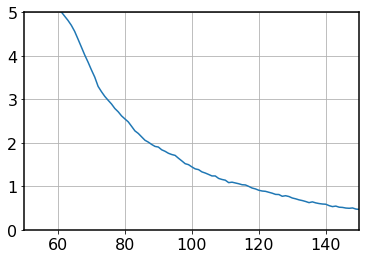

In [50]:
plt.plot(np.mean(losses-losses[-1,:], axis=1))
plt.ylim(0,5)
plt.xlim(50,150)
plt.grid()

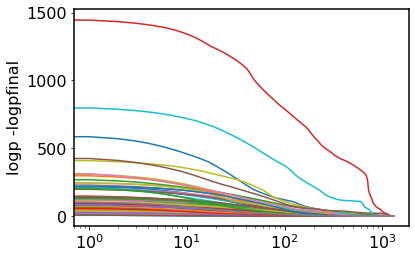

In [25]:
plt.semilogx(losses-losses[-1,:])
plt.ylabel('logp -logpfinal')
plt.show()

##### compute the Hessian

In [ ]:
#z_min = tf.convert_to_tensor(z_var)
z_    = tf.convert_to_tensor(z_ini)

with tf.GradientTape(persistent=True) as t1:
    t1.watch(z_)
    y    = posterior_eval(z_,LP.x,likelihood, nvp_funcs)[0]
    g    = t1.gradient(y, z_)
h = t1.jacobian(g, z_, experimental_use_pfor=False)
print(h.shape)

In [ ]:
h = np.moveaxis(h.diagonal(0,0,2),-1,0)

### Compute Laplace approximation

In [ ]:
# on full Hessian
p_x=[]
for ii in range(params['batch_size']):
    log_post = LP.logp(z_ini)[ii]
    H = -h[ii]
    sign_, lndet = np.linalg.slogdet(H)
    if sign_==-1:
        print(ii)
        H = np.diag(np.diag(H))
        sign_, lndet = np.linalg.slogdet(H)
    p_x.append(log_post-0.5*lndet)

#### compute Gauss-Newton Hessian

In [135]:
z_ = tf.convert_to_tensor(z_ini)
with tf.GradientTape(persistent=True, watch_accessed_variables=False) as tape:
    tape.watch(z_)
    y = decoder({'z':z_})['x']
    y = tf.reshape(y,(params['batch_size'],28*28))


In [137]:
g = tape.jacobian(y, z_, experimental_use_pfor=False)

In [138]:
g = np.moveaxis(g.numpy().diagonal(0,0,2),-1,0)

In [139]:

with tf.GradientTape(persistent=True, watch_accessed_variables=False) as tape:
    tape.watch(z_)
    u = nvp_funcs({'z_sample':z_,'sample_size':1, 'u_sample':np.zeros((1,params['latent_size']))})['bwd_pass']
    

In [140]:
J = tape.jacobian(u, z_, experimental_use_pfor=False)

In [141]:
J = J.numpy()

In [142]:
J = J.diagonal(0,0,2)

In [127]:
GNs=[]
for ii in range(params['batch_size']):
    dec_gradient=g[ii]
    term1 = np.dot(dec_gradient.T,dec_gradient*np.expand_dims(params['full_sigma'].flatten()**(-2),-1))
    term2 = np.dot(J[:,:,ii],J[:,:,ii].T)
    GN = term1+term2
    GNs.append(GN)


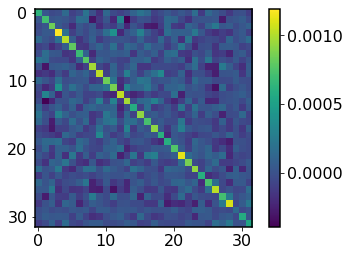

In [122]:
plt.imshow(np.linalg.inv(GNs[0]))
plt.colorbar()

#### Laplace evidence with Gauss-Newton Hessian

In [143]:
p_x=[]

for ii in range(params['batch_size']):
    log_post = LP.logp(z_ini)[ii]
    H   = GNs[ii]
    cov = np.linalg.inv(H)
    sign_, lndet = np.linalg.slogdet(cov)
    if sign_==-1:
        print(ii)
        H = np.diag(np.diag(H))
        cov = np.linalg.inv(H)
        sign_, lndet = np.linalg.slogdet(cov)
    else:
        p_x.append(log_post+0.5*lndet+params['latent_size']/2*np.log(2*np.pi))

In [146]:
np.mean(LP.logp(z_ini)), np.mean(LP.logp(z_min))

(1037.384, 1142.1575)

In [144]:
p_x=np.asarray(p_x)

In [145]:
p_x, np.mean(p_x)

(array([1232.3342  ,  545.96704 , 1283.7893  , 1193.4805  , 1109.8733  ,
        1223.4343  ,  635.8343  ,  241.13393 , 1222.4576  , 1093.6976  ,
        1091.0085  ,  695.4895  ,  857.9373  , 1260.3677  , 1189.1488  ,
        1226.497   ,  780.9115  , -763.477   , 1023.9597  , 1186.4684  ,
         257.82584 ,  997.12024 , 1214.526   ,  869.68036 , 1280.1887  ,
         801.1456  , 1167.6896  , 1266.235   , 1016.6262  , 1151.4918  ,
         741.45624 ,  624.48676 ,  573.5573  ,  905.13605 , 1065.2465  ,
         958.0801  ,  857.3966  , 1192.804   ,  973.9689  , 1094.2446  ,
        1217.7551  , 1261.8975  , 1240.1885  , 1081.6426  , 1138.6958  ,
        1038.17    , 1057.3429  , 1201.9203  ,  843.92413 , 1124.2653  ,
         929.0878  , 1014.7235  , 1153.5002  , -983.98596 , 1194.3511  ,
        1026.5994  ,  563.98944 , 1071.5583  ,  581.56647 , 1157.0438  ,
        1226.0724  , 1099.6149  ,  933.9672  ,  877.72675 , 1274.4402  ,
        1159.7303  ,  831.2372  , 1189.2999  ,  940

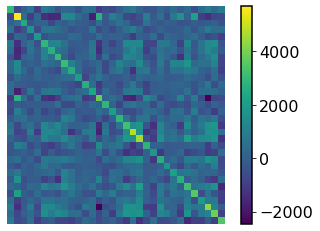

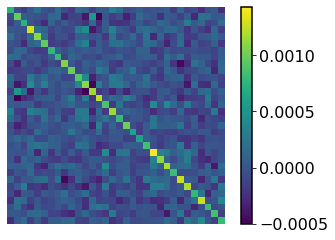

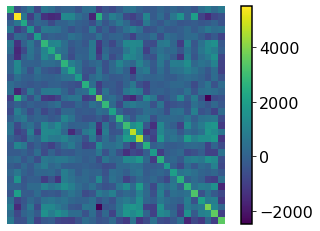

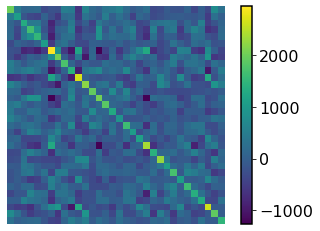

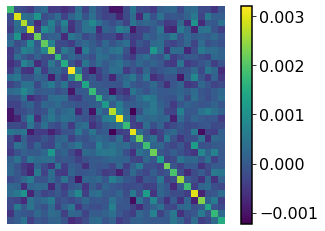

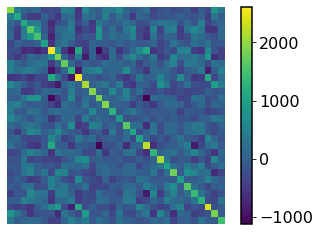

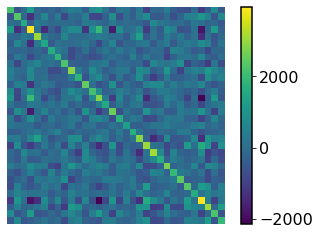

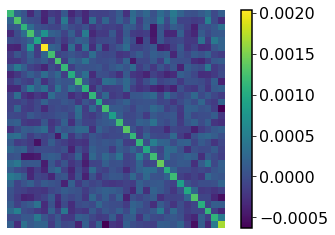

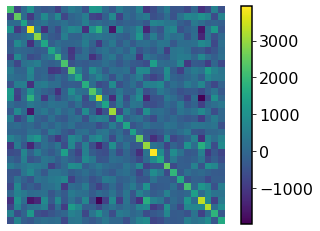

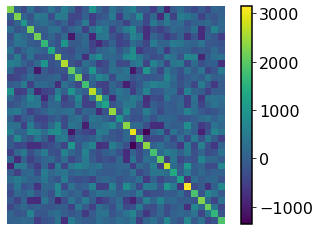

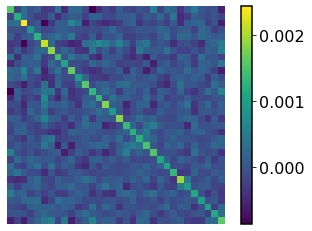

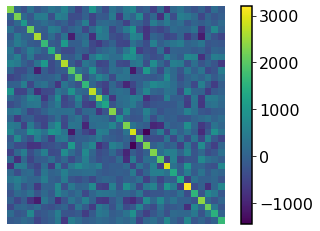

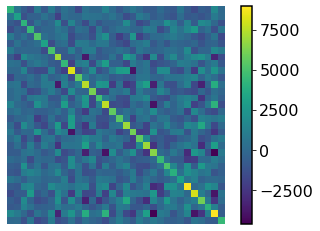

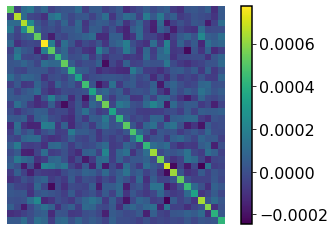

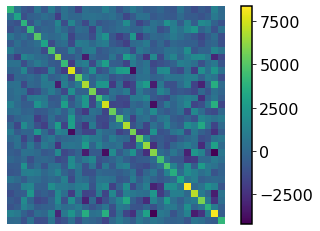

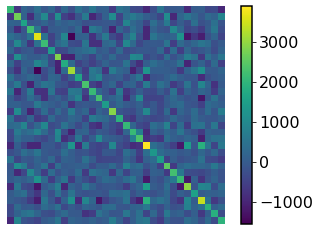

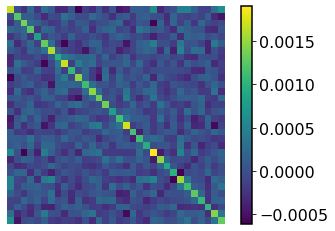

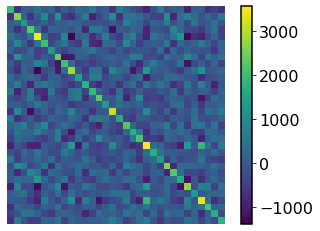

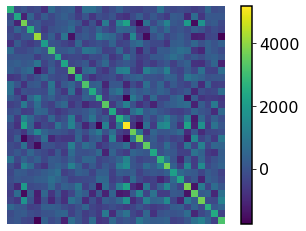

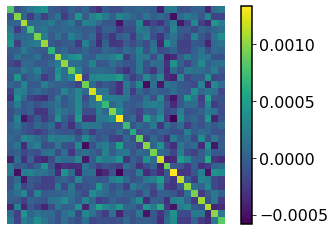

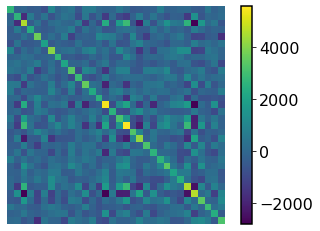

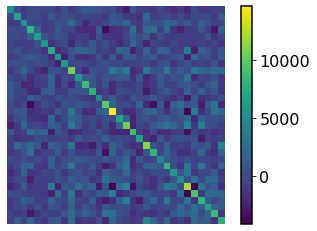

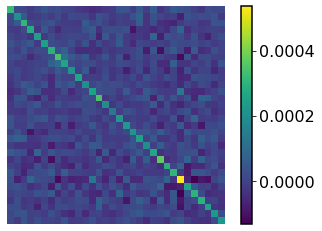

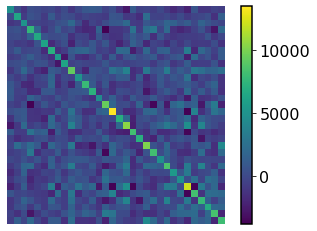

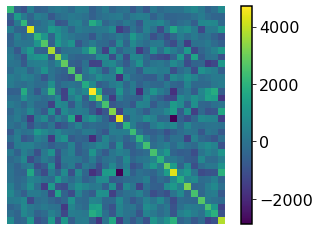

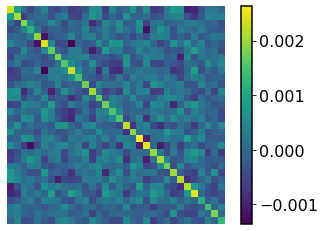

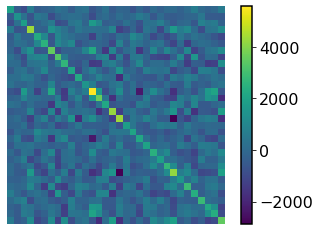

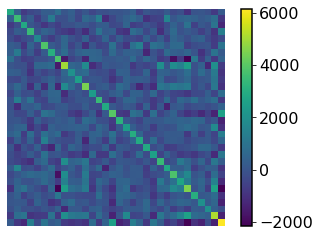

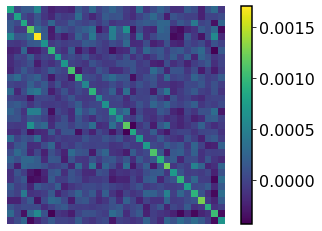

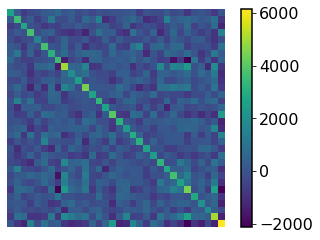

In [128]:

for ii in range(0,10):
   
    H = -h[ii,:,ii,:]
    try:
        _ = np.linalg.cholesky(H)
    except:
        print(ii)

    plt.imshow(H)
    plt.colorbar()
    plt.axis('off')
    plt.savefig(os.path.join(PLOT_PATH,'xtest_image%d_Hessian_PAE_zspace.pdf'%ii), bbox_inches='tight')
    plt.show()
    
    
    plt.imshow(np.linalg.inv(H))
    plt.colorbar()
    plt.axis('off')
    plt.savefig(os.path.join(PLOT_PATH,'xtest_image%d_cov_PAE_zspace.pdf'%ii), bbox_inches='tight')
    plt.show()

    plt.imshow(GNs[ii])
    plt.colorbar()
    plt.axis('off')
    plt.show()        

#     H_old=H

#### eigenvalue inspection

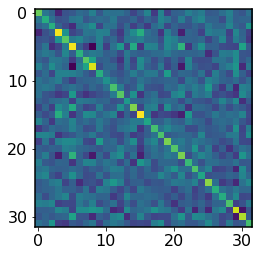

In [132]:
plt.imshow(np.linalg.inv(H))
cov    = np.linalg.inv(H)
eig, v = np.linalg.eigh(cov)

539.18567


4.7676065e-05

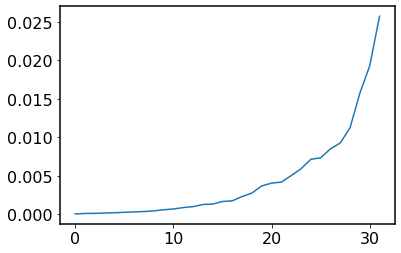

In [134]:
plt.plot(eig)
print(max(eig)/min(eig))
min(eig)

### Sampling or loading samples

In [5]:
filename= os.path.join(PROJECT_PATH,'PAE_samples/FMNIST/latent_dim32/PAE/samples','NUTS_FMNISTzspace_latent_dim32_burnin300_ntreelevel8_1batch2000.npy')
samples = np.load(filename)

In [19]:
import time

In [15]:
initial_step_size = np.ones((params['batch_size'],params['latent_size']))*0.01

In [16]:
# Initialize the HMC transition kernel.
num_results = int(2000)
print(num_results)

def get_kernel(ii,num_burnin_steps, ntreelevel):
    x     = x_test[ii*params['batch_size']:(ii+1)*params['batch_size']]
    LP    = LogP(x)
    z_ini = get_encoded(x)
    adaptive_hmc = tfp.mcmc.DualAveragingStepSizeAdaptation(
        tfp.mcmc.NoUTurnSampler(
            target_log_prob_fn=LP.logp,max_tree_depth= ntreelevel,
            #num_leapfrog_steps=num_lp_steps,
            step_size=initial_step_size),
            num_adaptation_steps=int(num_burnin_steps * 0.8))
    return adaptive_hmc, z_ini, LP

# Run the chain (with burn-in).
@tf.function()
def run_chain(adapative_hmc, z_ini, num_burnin_steps):
  # Run the chain (with burn-in).
    samples, [step_size, accept_ratio, leapfrogs] = tfp.mcmc.sample_chain(
      num_results      = num_results,
      num_burnin_steps = num_burnin_steps,
      current_state    = z_ini,
      kernel           = adaptive_hmc,
      trace_fn         = lambda _, pkr: [pkr.inner_results.step_size,
                             pkr.inner_results.is_accepted, pkr.inner_results.leapfrogs_taken])

    return samples, step_size, accept_ratio, leapfrogs

2000


In [ ]:
begin = time.time()
samples_ = []
for ii in range(0,1):
    print(ii)
    for jj, burnin in enumerate([300]):
        for nn,  ntreelevel in enumerate([8]):
            adaptive_hmc, z_ini, LP= get_kernel(ii,burnin, ntreelevel)
            samples, step_size, accept_ratio, leapfrogs = run_chain(adaptive_hmc, tf.convert_to_tensor(z_ini),tf.constant(burnin))
            end = time.time()-begin
            print(end)
            begin = time.time()
            samples_.append(samples)
            print(samples.shape)
            samples = np.swapaxes(np.asarray(samples_),1,2)
            print(samples.shape)
            samples = np.reshape(samples,(-1,num_results,params['latent_size']))
            print(samples.shape)
            filename= os.path.join(PROJECT_PATH,'PAE_samples/FMNIST/latent_dim32/PAE/samples','NUTS_FMNISTzspace_latent_dim%d_burnin%d_ntreelevel%d_1batch%d.npy'%(params['latent_size'], burnin, ntreelevel, num_results))
            np.save(filename,samples)
# print('time:', end/60)

### inspect samples


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



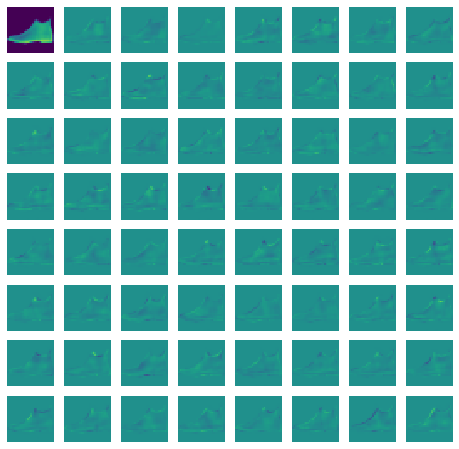

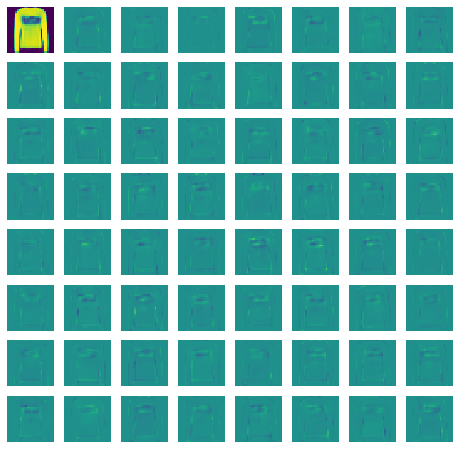

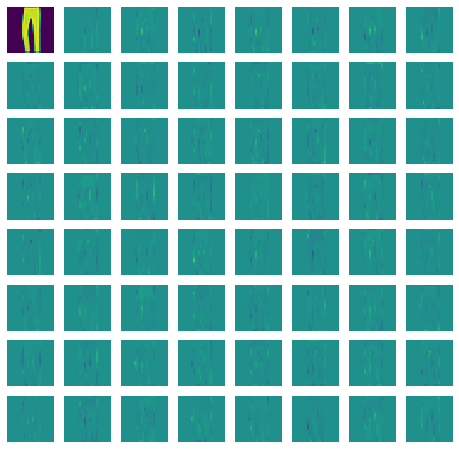

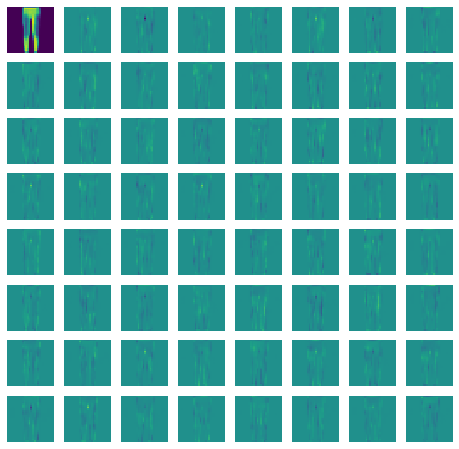

In [83]:
sub_select = np.random.choice(np.arange(100),8*8)
for jj in range(4):
    sub_samples = samples[jj,sub_select,:]
    plt.figure(figsize=(8,8))
    old_fig=np.zeros((28,28))
    for ii in range(8*8):
        plt.subplot(8,8,ii+1)
        fig = np.squeeze(get_decoded(build_container(sub_samples[ii]))[0])
        plt.imshow(fig-old_fig, vmin=-0.5, vmax=0.5)
        old_fig=fig
        plt.axis('off')
    plt.show()

In [77]:
import corner

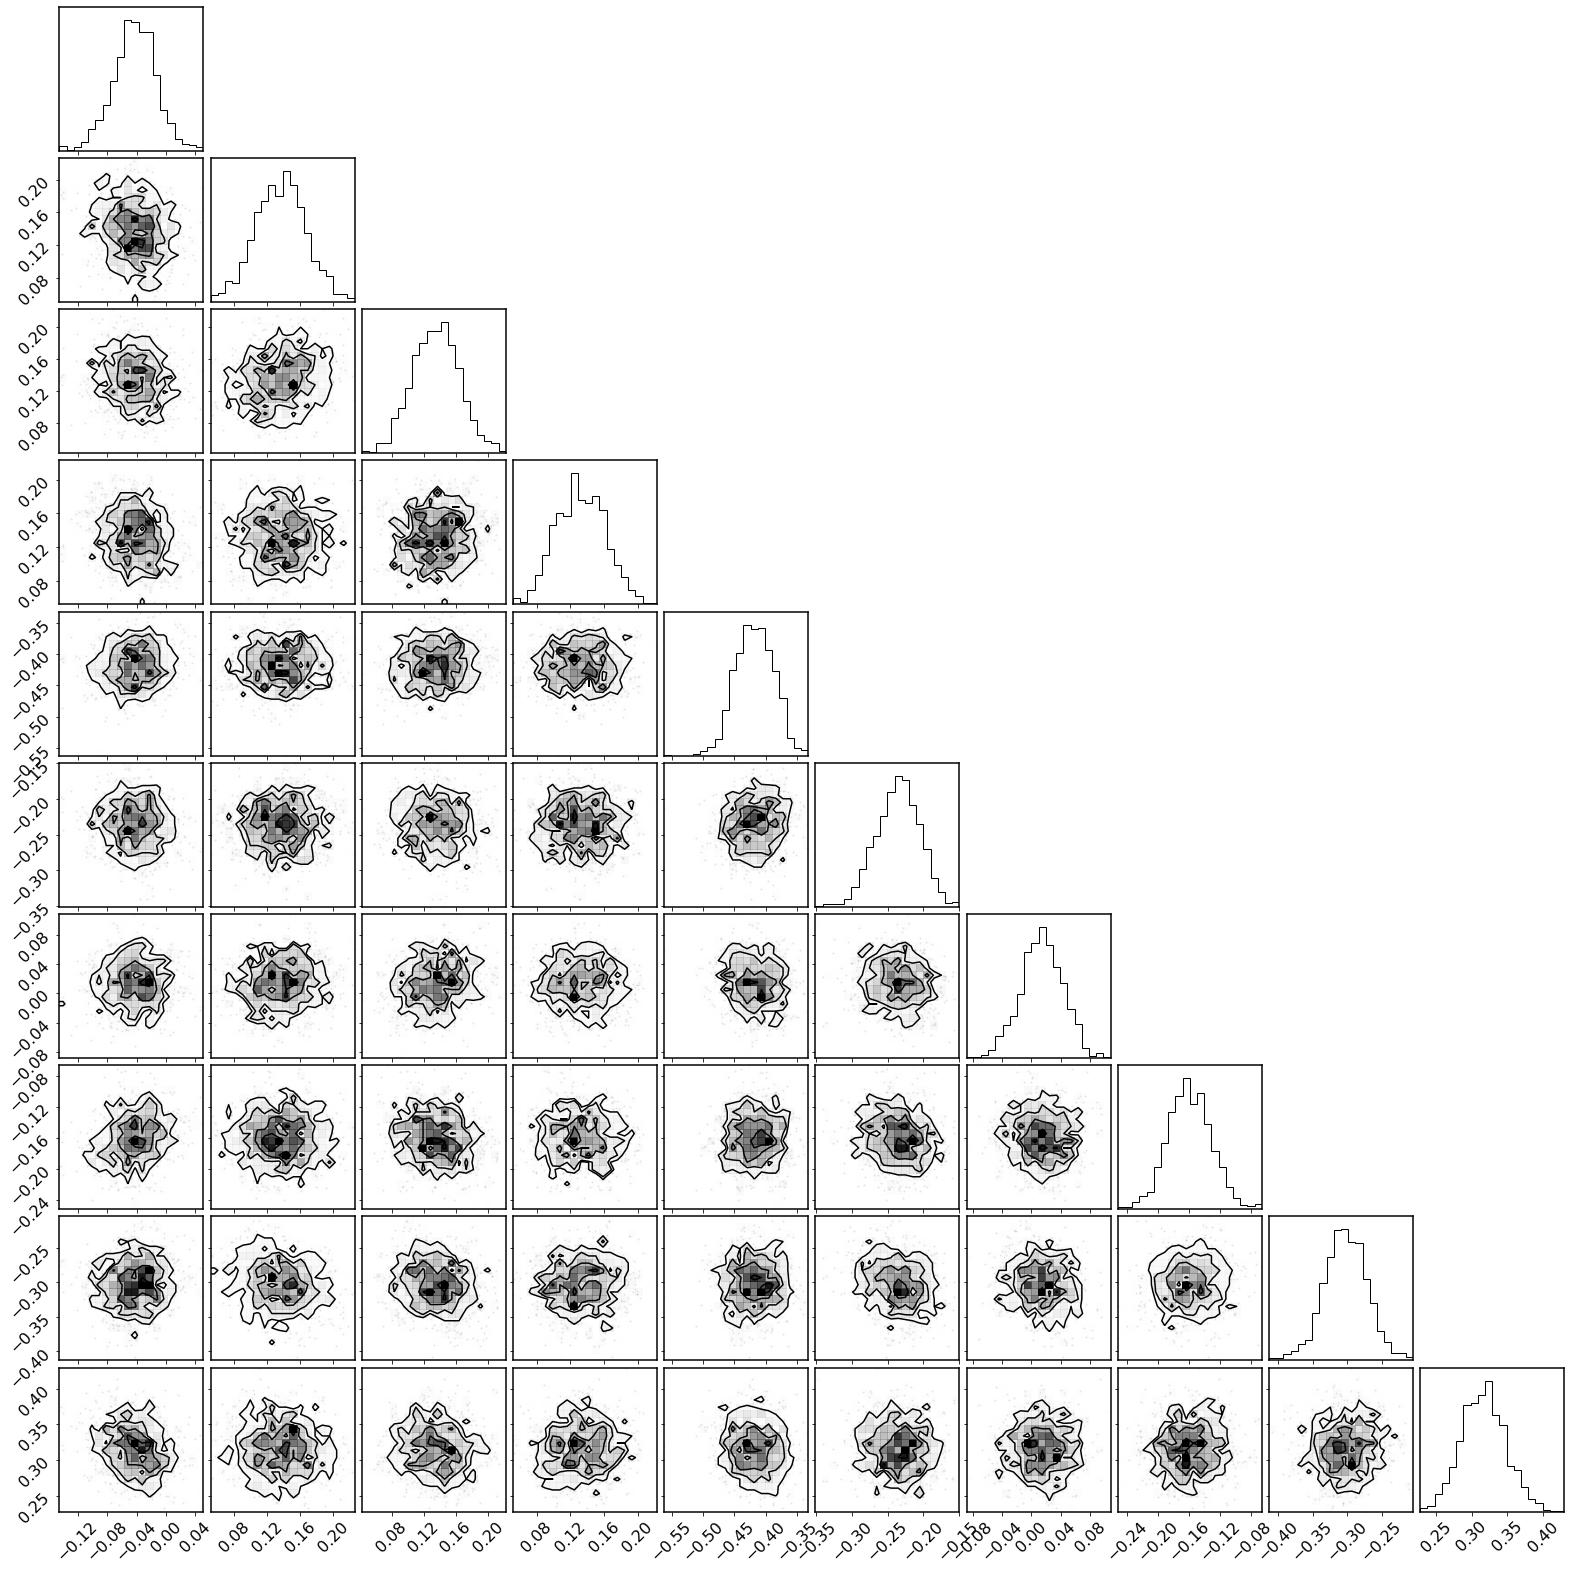

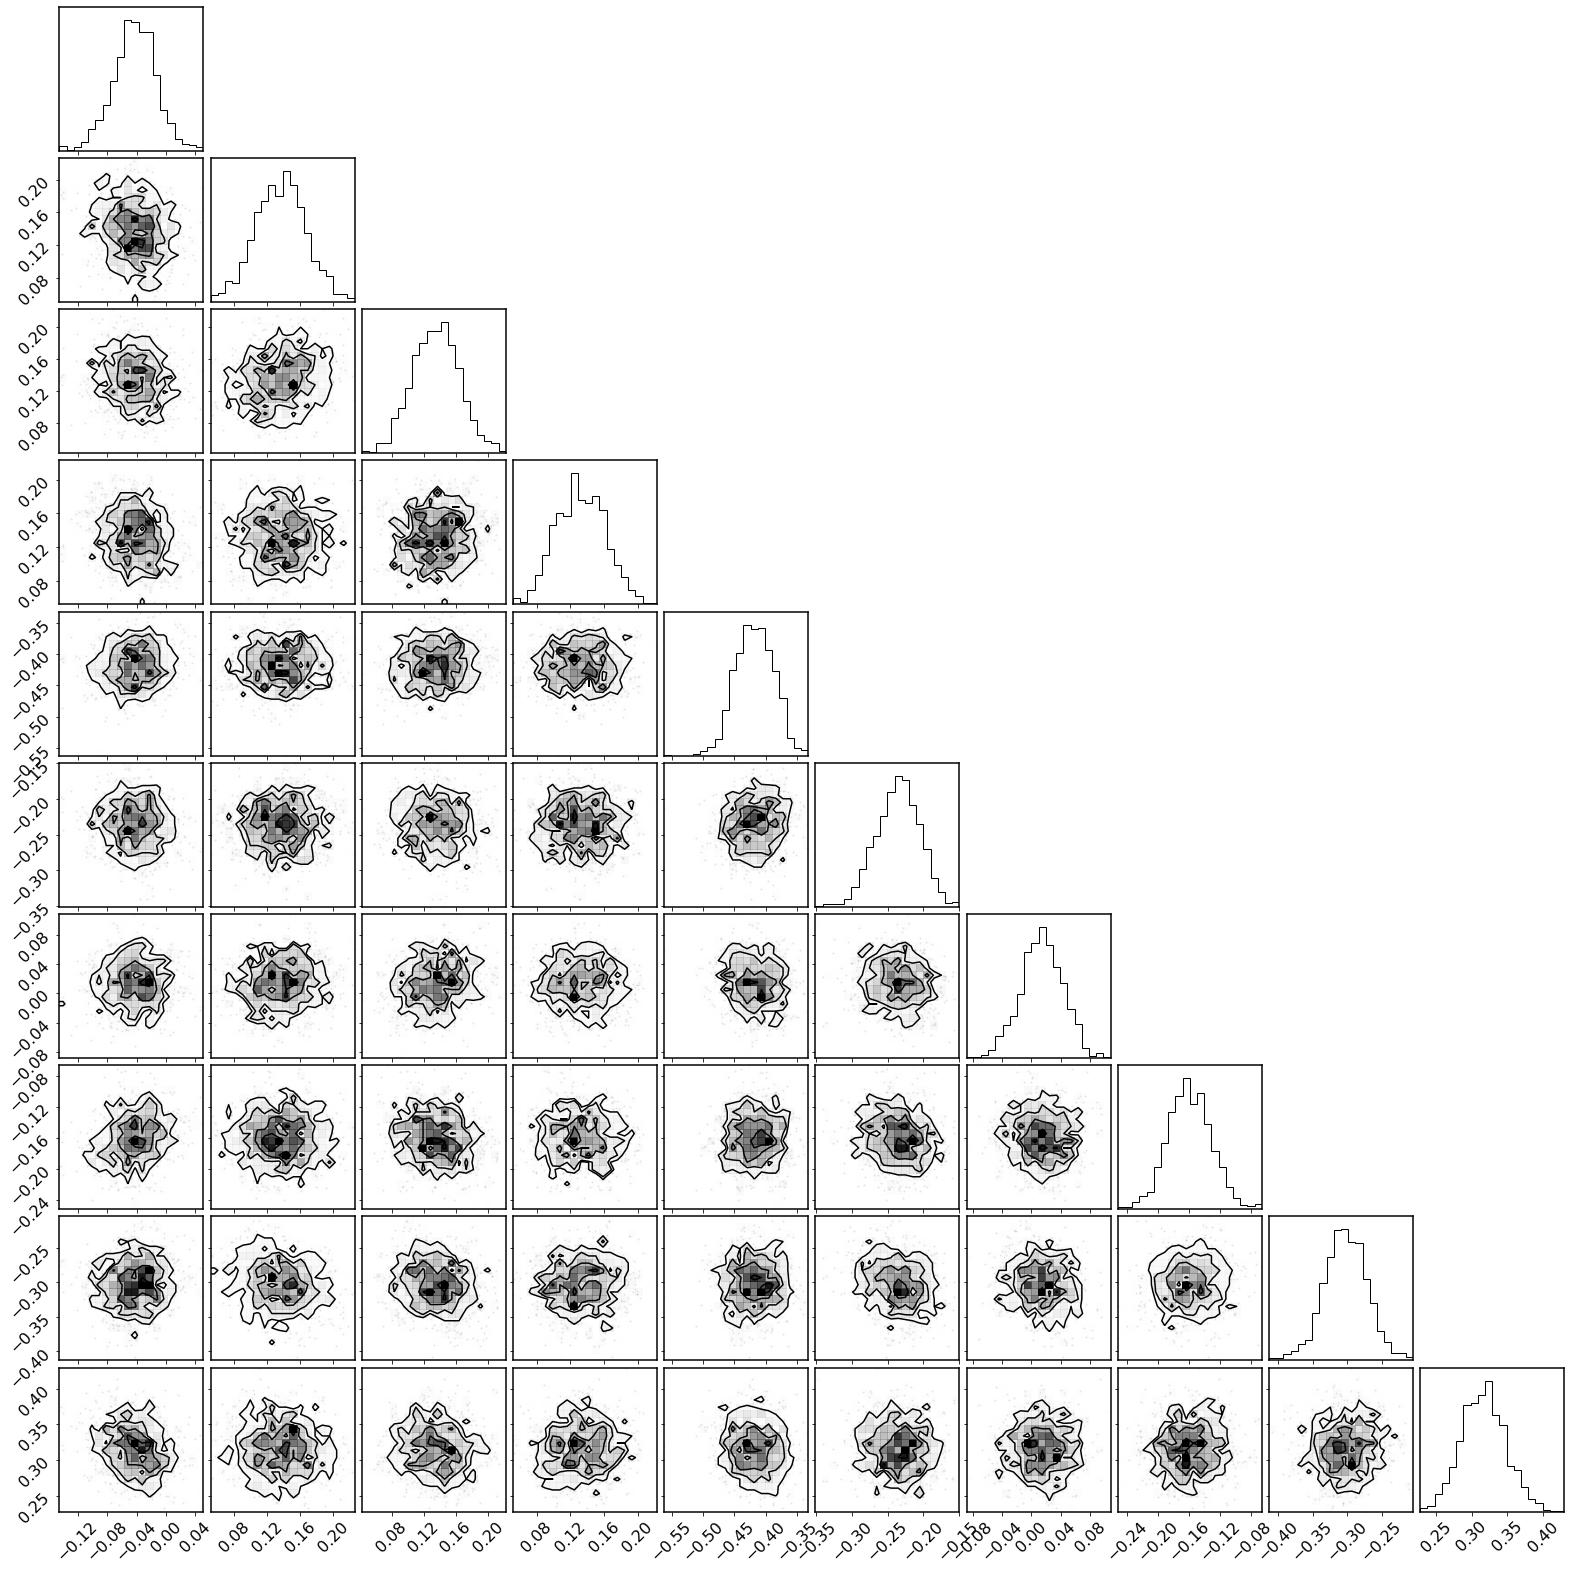

In [78]:
corner.corner(samples[0,:,0:10])

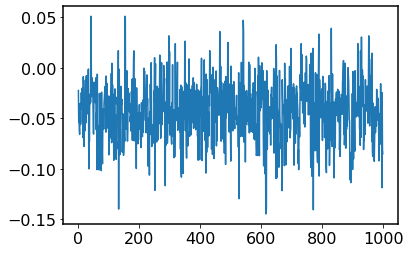

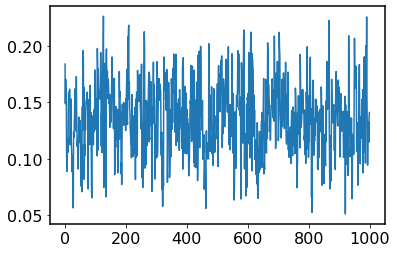

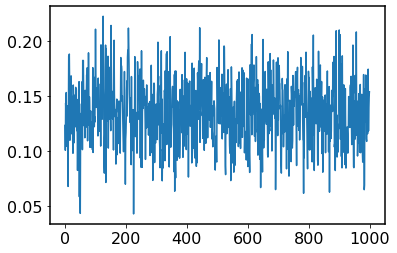

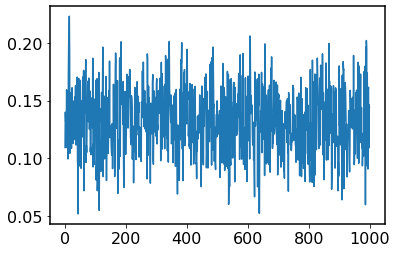

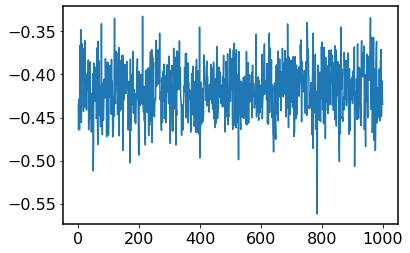

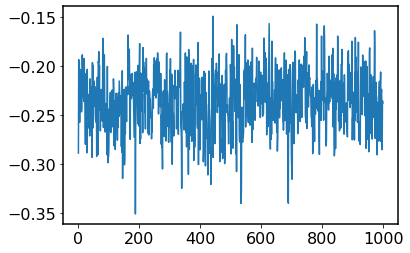

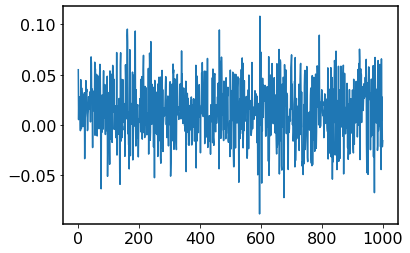

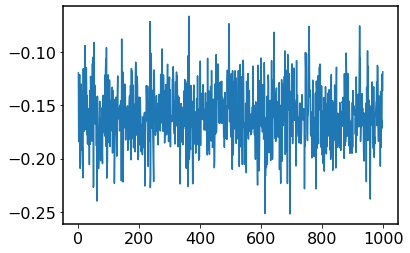

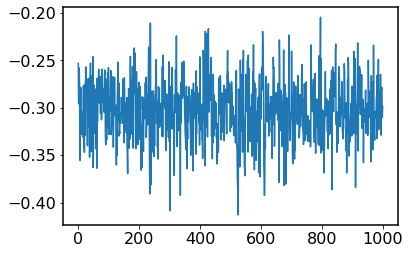

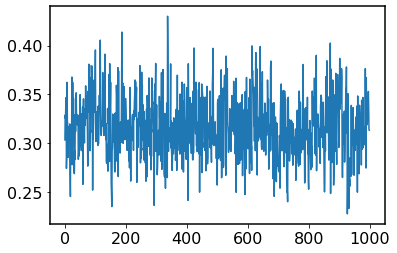

In [80]:
for ii in range(10):
    plt.plot(samples[0,:,ii])
    plt.show()

In [81]:


def next_pow_two(n):
    i = 1
    while i < n:
        i = i << 1
    return i

def autocorr_func_1d(x, norm=True):
    x = np.atleast_1d(x)
    if len(x.shape) != 1:
        raise ValueError("invalid dimensions for 1D autocorrelation function")
    n = next_pow_two(len(x))

    # Compute the FFT and then (from that) the auto-correlation function
    f = np.fft.fft(x - np.mean(x), n=2 * n)
    acf = np.fft.ifft(f * np.conjugate(f))[: len(x)].real
    acf /= 4 * n

    # Optionally normalize
    if norm:
        acf /= acf[0]

    return acf



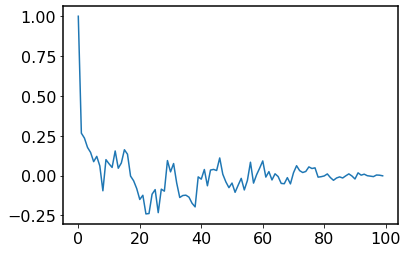

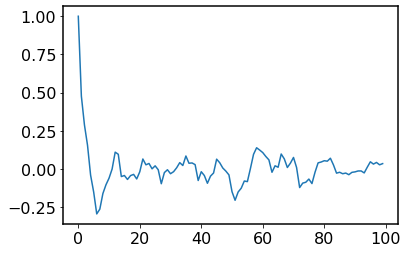

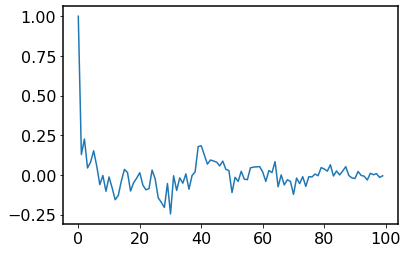

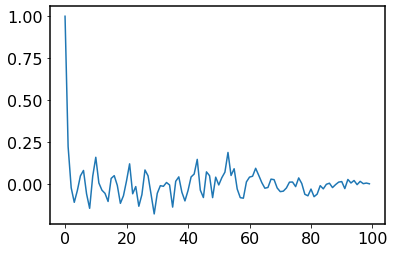

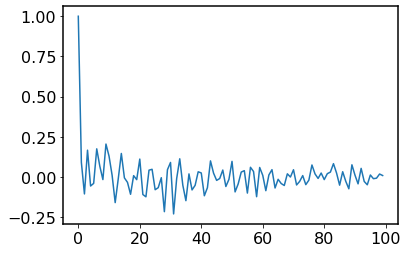

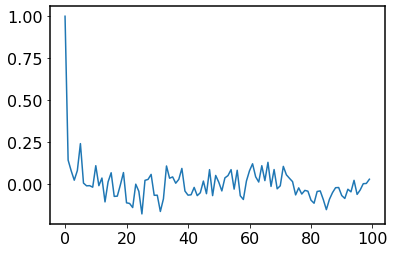

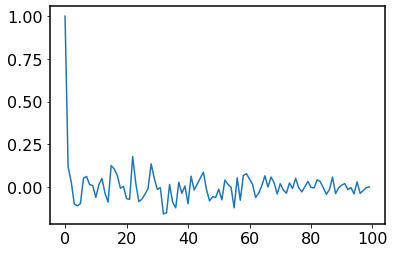

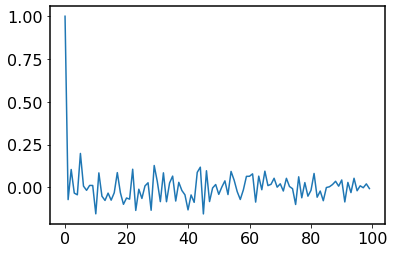

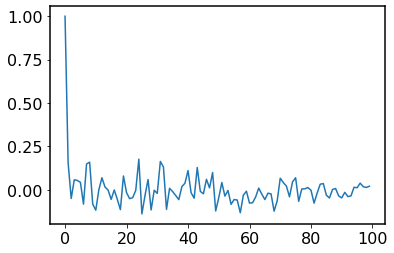

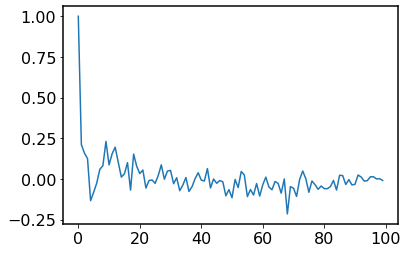

In [82]:


for ii in range(10):
    for n in [100]:
        acf = autocorr_func_1d(samples[0,:n,ii], norm=True)
        plt.plot(acf)
        plt.show()

